# K-Nearest Neighbors classifier for stroke prediction
### Import data

In [1]:
from data_processing import prepare_data, split_data, one_hot_encode
from oversampling import smote_loop
from helper_functions import get_metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

# Make the data into a pd dataframe
df = prepare_data('healthcare-dataset-stroke-data.csv', one_hot = True, binary = False, normalize = True)

# Split the data into training, testing and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(df, (0.6, 0.2, 0.2))

In [2]:
def split_datatypes(data):
    """
    Function that takes a dataframe as input and returns a dataframe with only the numeric columns and one with only 
    the binary columns. 
    """
    
    # Create empty list to store column names of numeric and of binary data
    numeric_names = []
    binary_names = []
    
    # Loop over al the names of the columns in the dataframe
    for column_name in data.columns:
        
        # Check if the column contains binary data by counting the number of unique values 
        if len(data[column_name].unique()) > 2:
            
            # Append name to numeric list if the column contains more than 2 unique values
            numeric_names.append(column_name)
            
        else:
            # Append name to binary list if the column contains 2 or less unique values
            binary_names.append(column_name)
    
    # Numeric data: age, avg_glucose_level, bmi 
    data_num = data.drop(columns = binary_names)
    
    # Binary data: hypertension, heart_disease, marriage status, rural/urban
    data_bin = data.drop(columns = numeric_names)
    
    return data_num, data_bin

# Split all data into numeric and binary data.
train_data_num, train_data_bin = split_datatypes(train_data)
test_data_num, test_data_bin = split_datatypes(test_data)
val_data_num, val_data_bin = split_datatypes(val_data)


## The K-Nearest Neighbor classification model


In [3]:
def train_and_predict(training_data, training_labels, testing_data, nr_neighbors = 5, weight_metric = "uniform", 
                      metric = 'euclidean'):
    """
    This function trains a nearest neighbors classifier, with nr_neighbors as the neighbors used for classification and
    a weight metric given as input, standard with every neighbor having the same weight. It outputs the predictions for the 
    testing data.
    """
        
    # Make an instance of the k-NN model
    knn = KNeighborsClassifier(nr_neighbors, weights=weight_metric, metric=metric) 

    # Fit the data to the model
    knn.fit(training_data, training_labels)
    
    # Predict the classes for the testing data
    predictions_train = knn.predict(training_data)
    predictions_test = knn.predict(testing_data)
    
    # Return predictions and accuracy on testing data
    return predictions_train, predictions_test

# Determine the amount of neighbours the algorithm will consider for the nearest neighbours classification
n_neighbors = 5

# Predictions using model with all features in dataset and euclidean distance.
predictions_train, predictions_test = train_and_predict(train_data, train_labels, val_data, n_neighbors, "distance", 
                                                        metric='euclidean')

# Predictions using model with only categorical data in dataset and jaccard distance metric
predictions_train_bin, predictions_test_bin = train_and_predict(train_data_bin, train_labels, test_data_bin, n_neighbors, 
                                                                "distance", metric='jaccard')

# Predictions using model with only numerical data in dataset and euclidean distance metric
predictions_train_num, predictions_test_num = train_and_predict(train_data_num, train_labels, test_data_num, n_neighbors, 
                                                                "distance", metric='euclidean')

# Get accuracy and balanced accuracy and print them.
print('predictions using numeric features:')
accuracy_test_num, balanced_accuracy_test_num = get_metrics(test_labels, predictions_test_num, verbose=True)

print('predictions using categorical features:')
accuracy_test_bin, balanced_accuracy_test_bin = get_metrics(test_labels, predictions_test_bin, verbose=True)

print('predictions using all features:')
accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test, verbose=True)


predictions using numeric features:
accuracy: 94.9119 % 

balanced accuracy: 51.7942 %
sensitivity: 0.0400
specificity: 0.9959 

confusion matrix: 
[[968   4]
 [ 48   2]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

predictions using categorical features:
accuracy: 95.3033 % 

balanced accuracy: 53.8971 %
sensitivity: 0.0800
specificity: 0.9979 

confusion matrix: 
[[970   2]
 [ 46   4]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

predictions using all features:
accuracy: 94.1292 % 

balanced accuracy: 49.4856 %
sensitivity: 0.0000
specificity: 0.9897 

confusion matrix: 
[[962  10]
 [ 50   0]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



### Actual model

Plot & find optimal K

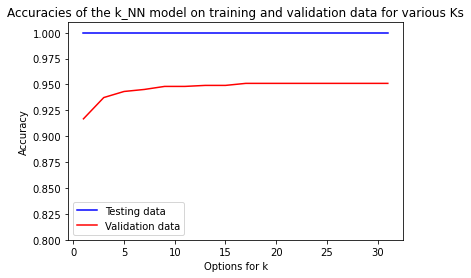

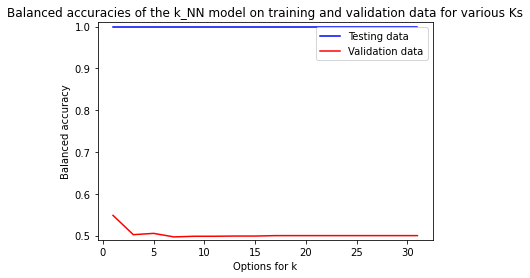

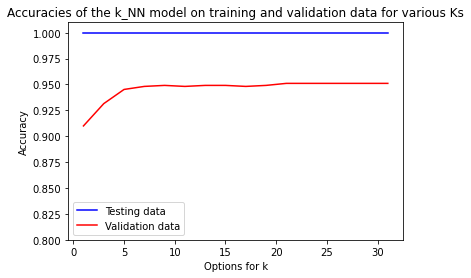

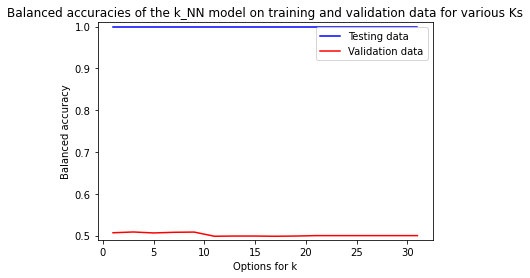

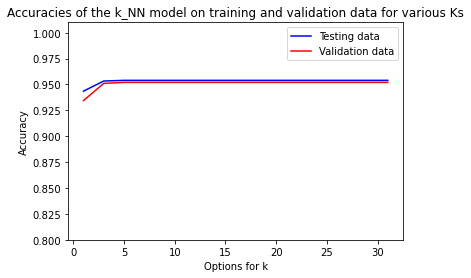

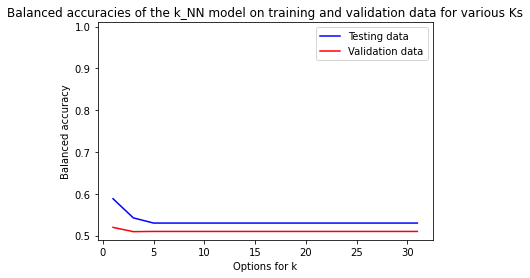

In [4]:
def plot_k(x, test_accuracies, validation_accuracies, title, xlab, ymin, ymax):
    """
    Plot the test and validation accuracies per x: the k-range. Give a title, x-axis label (xlab) as strings and desired min y 
    and max y as input as well.
    """
    plt.plot(x, test_accuracies, "b", label = "Testing data")
    plt.plot(x, validation_accuracies, "r", label = "Validation data")
    plt.legend()
    plt.title(title)
    plt.ylim(ymin, ymax)
    plt.ylabel(xlab)
    plt.xlabel("Options for k")
    plt.show()

def find_k(training_data, training_labels, valid_data, valid_labels, min_k, max_k, dist_metric = 'euclidean'):
    """ 
    This function calculates the (balanced) validation accuracy for every value for k between min_k and max_k for the k-Nearest
    neighbors model, using the training data and labels and validation data and labels. It is also possible to set the
    distance metric used for the k-NN model; default is euclidean distance. It returns a plot of all of the accuracies over
    various k values.
    """
    # Get a list of k values between the minimum and maximum, in steps of 2 because k should be always be uneven
    k_range = np.arange(min_k, max_k, 2)
    
    # Make lists to save the training (t) and validation (v) accuracies to, to plot later
    t_accuracies = []
    t_balanced_accuracies = []
    v_accuracies = []
    v_balanced_accuracies = []
    
    # Loop over all k values
    for k in k_range:
        
        # Get the predictions of the model for the training and validation data for this k
        t_predictions, v_predictions = train_and_predict(training_data, training_labels, valid_data, k, "distance", 
                                                         metric=dist_metric)
        
        # Get the accuracies for the training and validation data
        v_acc, v_balanced_acc = get_metrics(valid_labels, v_predictions, verbose = False)
        t_acc, t_balanced_acc = get_metrics(training_labels, t_predictions, verbose = False)
        
        # Add these accuracies to the lists
        t_accuracies.append(t_acc)
        t_balanced_accuracies.append(t_balanced_acc)
        v_accuracies.append(v_acc)
        v_balanced_accuracies.append(v_balanced_acc)
    
    # Plot the relationship between k and the accuracies; set a custom y-lim to show the differences in accuracies more clearly
    plot_k(k_range, t_accuracies, v_accuracies, "Accuracies of the k_NN model on training and validation data for various Ks", 
          "Accuracy", 0.8, 1.01)
    
    plot_k(k_range, t_balanced_accuracies, v_balanced_accuracies, "Balanced accuracies of the k_NN model on training and validation data for various Ks",
          "Balanced accuracy", 0.49, 1.01)

    
find_k(train_data, train_labels, val_data, val_labels, 1, 33)
find_k(train_data_num, train_labels, val_data_num, val_labels, 1, 33)

# Plot only the categorical features; use jaccard distance
find_k(train_data_bin, train_labels, val_data_bin, val_labels, 1, 33, "jaccard")

##### Improvements
1. Combine predictions from numerical and categorical models

In [7]:
# Combined prediction (if any of both predicts stroke, than prediction is stroke)
predictions_test = predictions_test_num + predictions_test_bin > 0
predictions_train = predictions_train_num + predictions_train_bin > 0

print('combined predictions for both categorical and numerical data:')
accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test, verbose=True)


combined predictions for both categorical and numerical data:
accuracy: 95.1076 % 

balanced accuracy: 55.6914 %
sensitivity: 0.1200
specificity: 0.9938 

confusion matrix: 
[[966   6]
 [ 44   6]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



2. Use oversampled data

In [22]:
# Load the data as a pd dataframe without one_hot encoding
df = prepare_data('healthcare-dataset-stroke-data.csv', one_hot = False, binary = False, normalize = True)

# Split the data into training, testing and validation data
train_over, test_over, val_over, train_labels_over, test_labels_over, val_labels_over = split_data(df, (0.6, 0.2, 0.2))

# Change testing and validation data to one hot encoded data, since this also happens to training data in smote_loop
test_over = one_hot_encode(test_over)
val_over = one_hot_encode(val_over)

# Split all data into numeric and binary data
test_over_num, test_over_bin = split_datatypes(test_over)
val_over_num, val_over_bin = split_datatypes(val_over)

# Get the lists with oversampled dataframes in ratios from 0 to 1 in steps of 0.01
data_over, labels_over, ratio_over = smote_loop(train_over, train_labels_over, 0.1, 1.1, 0.1)

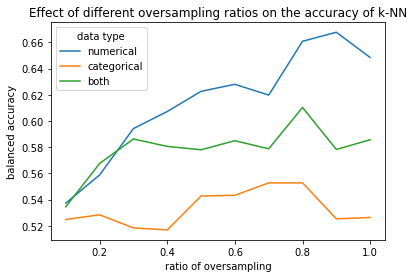

In [26]:
# Initiate the balanced accuracy lists for both normal and balanced accuracy and numerical and binary data
oversampling_bal = []
oversampling_bal_bin = []
oversampling_bal_both = []

# Loop over the dataframes in the list with dataframes and their place in the list
for i, dataframe in enumerate(data_over):
    
    # Split the training dataframe based on categorical and binary data
    train_over_num, train_over_bin = split_datatypes(dataframe)
    
    # Predictions using model with only numerical data in dataset and euclidean distance metric
    predict_train_num_over, predict_test_num_over = train_and_predict(train_over_num, labels_over[i], val_over_num,  
                                                                n_neighbors, "distance", metric='euclidean')
    
    # Predictions using model with only binary data in dataset and a jaccard distance metric
    predict_train_bin_over, predict_test_bin_over = train_and_predict(train_over_bin, labels_over[i], val_over_bin,  
                                                                n_neighbors, "distance", metric='jaccard')
    
    # Predictions using model with only numerical data in dataset and euclidean distance metric
    predict_train_both, predict_test_both = train_and_predict(dataframe, labels_over[i], val_over,  
                                                                n_neighbors, "distance", metric='euclidean')
    
    # Get accuracy and balanced accuracy
    accuracy_test_num, balanced_accuracy_test_num = get_metrics(val_labels_over, predict_test_num_over, verbose=False)
    accuracy_test_bin, balanced_accuracy_test_bin = get_metrics(val_labels_over, predict_test_bin_over, verbose=False)
    accuracy_test_both, balanced_accuracy_test_both = get_metrics(val_labels_over, predict_test_both, verbose=False)
    
    # Append accuracies to lists 
    oversampling_bal.append(balanced_accuracy_test_num)
    oversampling_bal_bin.append(balanced_accuracy_test_bin)
    oversampling_bal_both.append(balanced_accuracy_test_both)

# Plot the balanced accuracies for different oversampling ratios for all types of data
plt.plot(ratio_over, oversampling_bal)
plt.plot(ratio_over, oversampling_bal_bin)
plt.plot(ratio_over, oversampling_bal_both)
plt.title('Effect of different oversampling ratios on the accuracy of k-NN')
plt.ylabel('balanced accuracy')
plt.xlabel('ratio of oversampling')
plt.legend(['numerical', 'categorical', 'both'], title = 'data type')

plt.show()

In [28]:
index_max = np.argmax(oversampling_bal)
over_ratio = ratio_over[index_max]
high_balanced = oversampling_bal[index_max]
print(f"{over_ratio} with {high_balanced} accuracy")

0.9 with 0.6676954732510287 accuracy


Best value + we see that numeric value is best, use on training data:

In [25]:
num_train = split_datatypes(data_over[index_max])[0]
num_labels = labels_over[index_max]

predict_train_num_over, predict_test_num_over = train_and_predict(num_train, num_labels, test_over_num,  
                                                                n_neighbors, "distance", metric='euclidean')

print("Training data:")
get_metrics(num_labels, predict_train_num_over, verbose = True);

print("Testing data:")
get_metrics(test_labels_over, predict_test_num_over, verbose = True);



Training data:
accuracy: 100.0000 % 

balanced accuracy: 100.0000 %
sensitivity: 1.0000
specificity: 1.0000 

confusion matrix: 
[[2916    0]
 [   0 2624]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

Testing data:
accuracy: 81.8004 % 

balanced accuracy: 68.6152 %
sensitivity: 0.5400
specificity: 0.8323 

confusion matrix: 
[[809 163]
 [ 23  27]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



### Plot the data with k-NN decision boundaries
These plots show that given the unbalanced data with little stroke samples, the k-NN classifier simply does not work. This is also due to the fact that the continuous variables visualised here do not seem to cluster the data neatly between stroke and no stroke samples. however, only 2 features are plotted at the same time here, while multidimensional data could do better at clustering the data. 

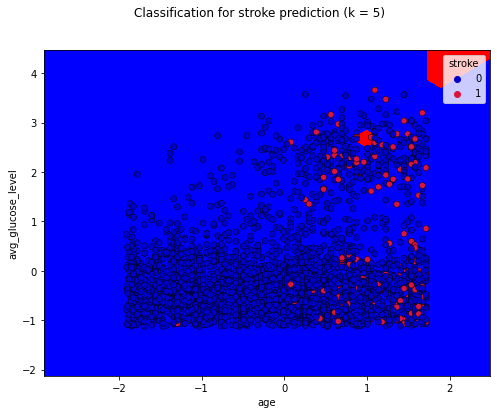

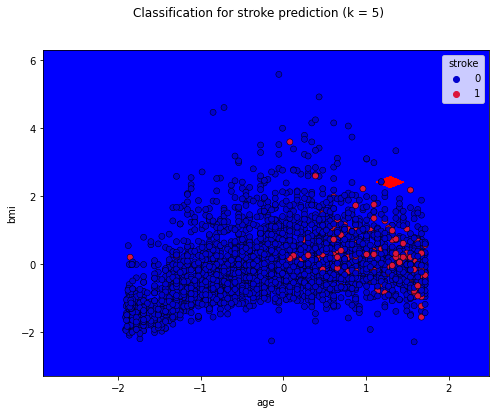

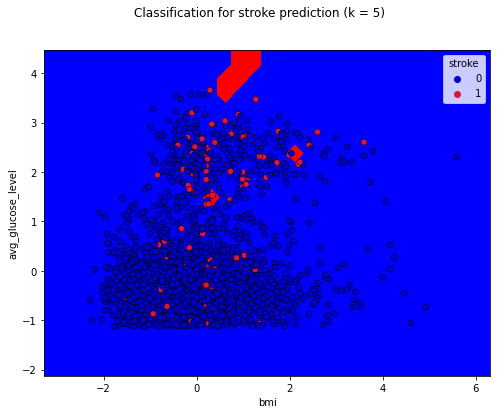

In [49]:
# Plot some features of the k-NN model, just mostly to get a feel for what the data looks like

def plot_knn(X, y, n_neighbors = 5, suptitle = None):
    """
    This function plots a k Nearest Neighbours model with 2 features, using a meshgrid. Input is an X matrix with
    feature data and an y vector with class labels. It is possible to set the amount of neighbours that is looked at, default
    = 5.
    """

    # Code for plot by : https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
    # Step size in the mesh; determines how precise the patches are plotted
    h = 0.3  

    # Create color maps, colours equal to categories of output data
    cmap_light = ListedColormap(['blue', 'red'])
    
    # The colormap for the dots in the scatterplot
    cmap_bold = ['MediumBlue', 'Crimson']

    # Create an instance of Neighbours Classifier and fit the data.
    model = KNeighborsClassifier(n_neighbors, weights ='uniform') 
    model.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot the training points as well
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette=cmap_bold, alpha=1.0, edgecolor="black")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(suptitle)
    plt.suptitle(f"Classification for stroke prediction (k = {n_neighbors})")

    # Get the names of the x and y axis from the dataframe
    plt.xlabel(f"{X.iloc[:, 0].name}")
    plt.ylabel(f"{X.iloc[:, 1].name}")
    plt.show()

# Get two features with continues values to plot; for this we have age, bmi and average glucose level
# Plotting all the features would be too many dimensions, so plot 2 at a time
plot_knn(train_data[["age", "avg_glucose_level"]], train_labels)
plot_knn(train_data[["age", "bmi"]], train_labels)
plot_knn(train_data[["bmi", "avg_glucose_level"]], train_labels)

Below are plots with only two features at a time, but this time with the oversampled data. After oversampling the data, you get plots with more clear red areas (so areas where new points will be classified as stroke). You can see the red areas increase in size as the oversampling increases. 

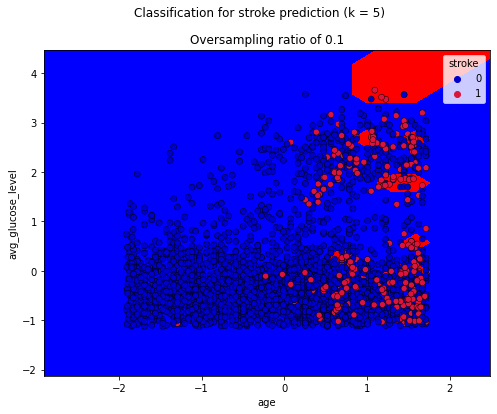

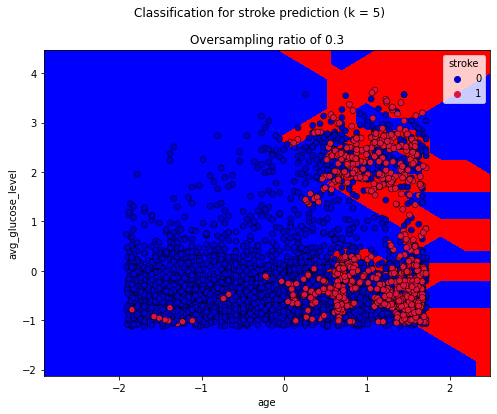

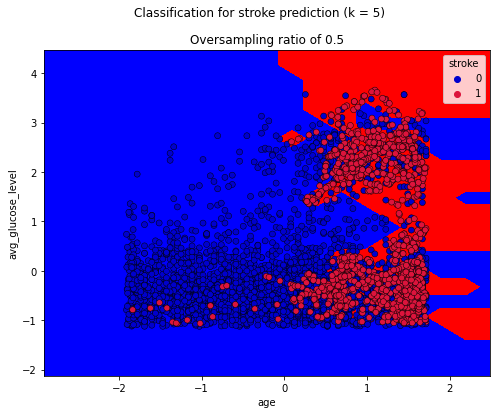

In [50]:
# Plot the datapoints from the training data with their corresponding labels for different oversampling ratios
plot_knn(data_over[0][["age", "avg_glucose_level"]], labels_over[0], suptitle = f"Oversampling ratio of {ratio_over[0]:.2}")
plot_knn(data_over[2][["age", "avg_glucose_level"]], labels_over[2], suptitle = f"Oversampling ratio of {ratio_over[2]:.2}")
plot_knn(data_over[4][["age", "avg_glucose_level"]], labels_over[4], suptitle = f"Oversampling ratio of {ratio_over[4]:.2}")